In [1]:
import sys
sys.path.append("../src/model/")
from pinsky_rinzel_model import PinskyRinzelModel
from CA1network import CA1Network
import numpy as np
import tqdm

In [2]:
# Parameters
w_tilde = 0.01
num_ca1_neurons = 100      # CA1ニューロン数 (論文 Figure 9で100まで)
num_ca3_neurons = 100
num_ca3_patterns = 20      # M=100 (論文では具体的な値が指定されていない)
num_ca3_patterns_input = 3 # m=3 (主成分空間の次元と一致させる)
t_interval_T = 100.0       # T=100ms (論文 Figure 4) 
duration_delta = 5.0       # delta=5ms (論文 Section 3.1) 
sim_dt = 0.05              # シミュレーションタイムステップ 
neuron_type  = ["bursting" for _ in range(num_ca1_neurons)]
synapse_type = ["BOTH"     for _ in range(num_ca1_neurons)]
sequence_length = 1000     # T間隔の数
t_span_network = (0, t_interval_T * sequence_length) # 0ms から 1000ms
rng = np.random.default_rng(42)
selected_numbers = rng.choice(range(num_ca3_patterns), size=num_ca3_patterns_input, replace=False)
#print(selected_numbers)
ca3_input_sequence = rng.integers(0, num_ca3_patterns_input, size=sequence_length).tolist()
for input_idx in range(sequence_length):
    ca3_input_sequence[input_idx] = selected_numbers[ca3_input_sequence[input_idx]]

In [3]:
print(f"Initializing CA1 Network with {num_ca1_neurons} neurons...")
ca1_network = CA1Network(
    num_ca1_neurons=num_ca1_neurons,
    num_ca3_neurons=num_ca3_neurons,
    num_ca3_patterns=num_ca3_patterns,
    num_ca3_patterns_input=num_ca3_patterns_input,
    neuron_type=neuron_type,
    synapse_type=synapse_type,
    w_tilde = w_tilde,
    dt=sim_dt,
    seed=42
)
print("CA1 Network Initialized.")

Initializing CA1 Network with 100 neurons...
CA1 Network Initialized.


In [4]:
import time
start = time.time()
print(f"Starting network simulation for {t_span_network[1]} ms...")
network_sol = ca1_network.simulate_network(
    t_span=t_span_network,
    ca3_input_sequence=ca3_input_sequence,
    ca3_input_interval_T=t_interval_T,
    ca3_input_duration_delta=duration_delta,
)
end = time.time()
print(f"Network simulation completed.")
print(f"Elapsed time: {end - start}")

Starting network simulation for 100000.0 ms...
Network simulation completed.
Elapsed time: 597.5487675666809


In [5]:
from matplotlib import pyplot as plt


Starting PCA and 3D plotting...
Shape of data for PCA (intervals x neurons): (1000, 100)
Shape of principal components: (1000, 3)
Explained variance ratio: [0.82770149 0.16180806 0.00994987]
Cumulative explained variance: 0.9994594245791009


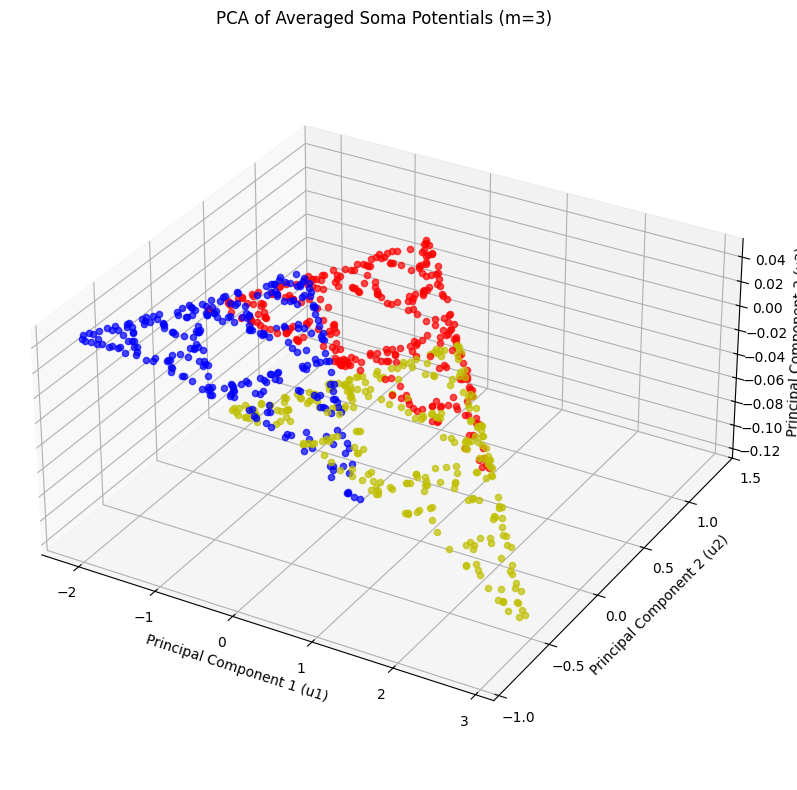

In [6]:
fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

from sklearn.decomposition import PCA

print("\nStarting PCA and 3D plotting...")
X_pca = network_sol.averaged_vs_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        if ca3_input_sequence[i] == selected_numbers[0]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="r",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[1]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="b",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[2]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="y",
                       s=20, alpha=0.7)
ax_pca.set_box_aspect((1, 1, 0.5)) 
ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of Averaged Soma Potentials (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()


Starting PCA and 3D plotting...
Shape of data for PCA (intervals x neurons): (1000, 100)
Shape of principal components: (1000, 3)
Explained variance ratio: [0.82770149 0.16180806 0.00994987]
Cumulative explained variance: 0.9994594245791009


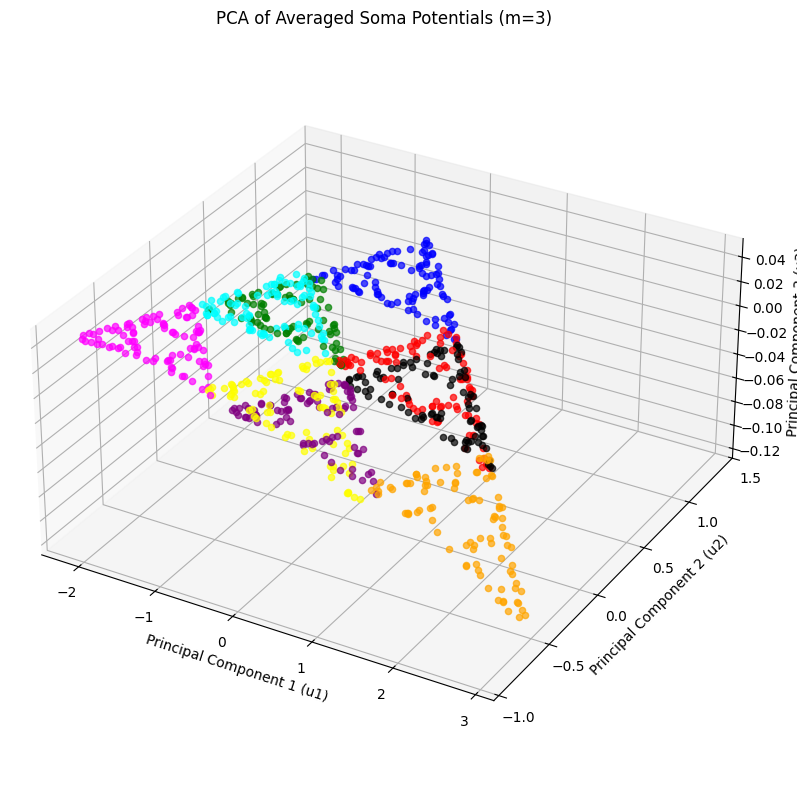

In [7]:
from sklearn.decomposition import PCA

my_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']

fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting...")
X_pca = network_sol.averaged_vs_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        for last_input_idx1 in range(3):
            for last_input_idx2 in range(3):
                if ca3_input_sequence[i] == selected_numbers[last_input_idx1]:
                    if ca3_input_sequence[i-1] == selected_numbers[last_input_idx2]:
                        ax_pca.scatter(principal_components[i, 0], 
                                       principal_components[i, 1], 
                                       principal_components[i, 2], 
                                       color=my_colors[last_input_idx1 * 3 + last_input_idx2],
                                       s=20, alpha=0.7)
ax_pca.set_box_aspect((1, 1, 0.5)) 
ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of Averaged Soma Potentials (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()


Starting PCA and 3D plotting...
Shape of data for PCA (intervals x neurons): (1000, 100)
Shape of principal components: (1000, 3)
Explained variance ratio: [nan nan nan]
Cumulative explained variance: nan


/home/satoshi/Yamaguti_etal_2011/venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


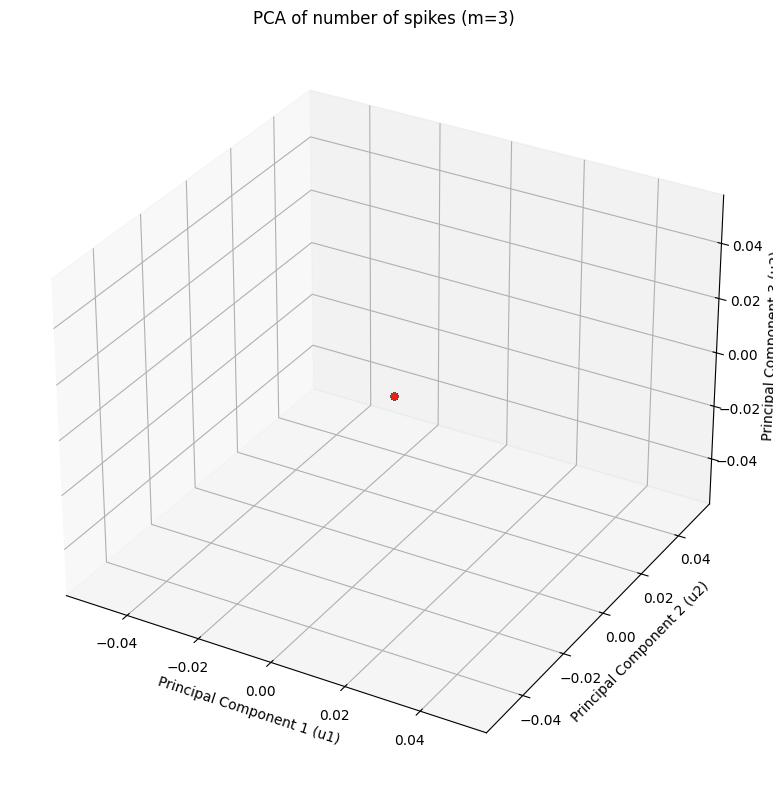

In [8]:
fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting...")
X_pca = network_sol.spike_counts_matrix.T
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        if ca3_input_sequence[i] == selected_numbers[0]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="r",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[1]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="b",
                       s=20, alpha=0.7)
        elif ca3_input_sequence[i] == selected_numbers[2]:
            ax_pca.scatter(principal_components[i, 0], 
                       principal_components[i, 1], 
                       principal_components[i, 2], 
                       color="y",
                       s=20, alpha=0.7)

ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of number of spikes (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()


Starting PCA and 3D plotting...
Shape of data for PCA (intervals x neurons): (1000, 100)
Shape of principal components: (1000, 3)
Explained variance ratio: [nan nan nan]
Cumulative explained variance: nan


/home/satoshi/Yamaguti_etal_2011/venv/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:646: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


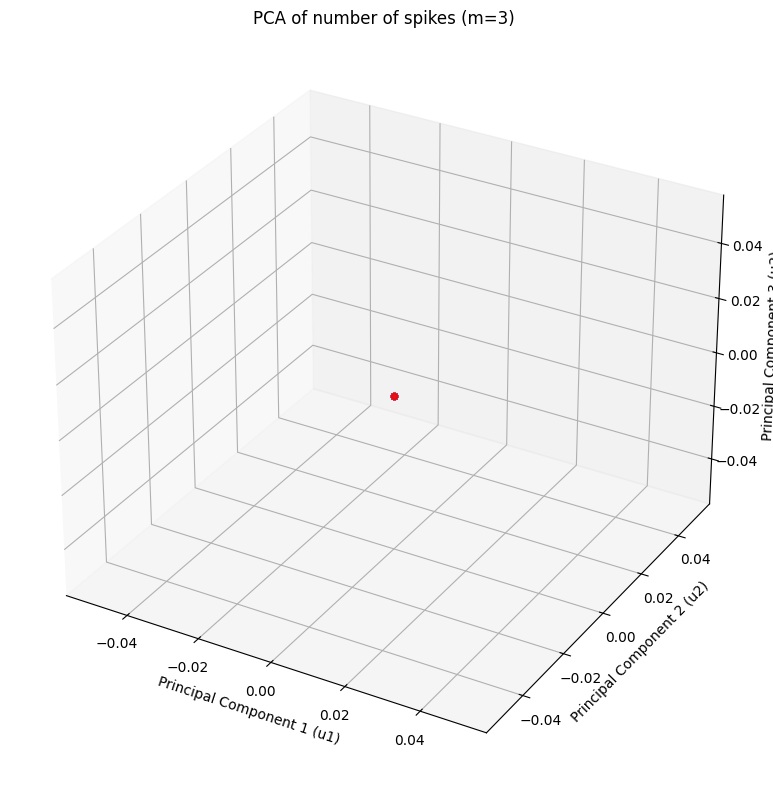

In [9]:
from sklearn.decomposition import PCA

my_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']

fig_pca = plt.figure(figsize=(10, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

print("\nStarting PCA and 3D plotting...")
X_pca = network_sol.spike_counts_matrix.T 
print(f"Shape of data for PCA (intervals x neurons): {X_pca.shape}")
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pca)
print(f"Shape of principal components: {principal_components.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_)}")
for i in range(sequence_length):
    if i > 150:
        for last_input_idx1 in range(3):
            for last_input_idx2 in range(3):
                if ca3_input_sequence[i] == selected_numbers[last_input_idx1]:
                    if ca3_input_sequence[i-1] == selected_numbers[last_input_idx2]:
                        ax_pca.scatter(principal_components[i, 0], 
                                       principal_components[i, 1], 
                                       principal_components[i, 2], 
                                       color=my_colors[last_input_idx1 * 3 + last_input_idx2],
                                       s=20, alpha=0.7)

ax_pca.set_xlabel('Principal Component 1 (u1)')
ax_pca.set_ylabel('Principal Component 2 (u2)')
ax_pca.set_zlabel('Principal Component 3 (u3)')
ax_pca.set_title(f'PCA of number of spikes (m={ca1_network.num_ca3_patterns_input})')
ax_pca.grid(True)
plt.tight_layout()